In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# preparing data
from models import *
from methods import *
import pandas as pd
import torch
import os
from os import path
from sklearn.manifold import TSNE

DATASET = 'original_data'
"""___________________Hyper Parameters________________________"""
MODEL_NAME = ['AE',]
#MODEL_NAME = ['DAE', 'VAE']
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = [False]
FILTER_CORRCOEF = [False]
REMOVE_NOISE = [False]
NOISE_THRESHOLD = [10]
NOISE_FACTOR = [1, 0.5]
NOISE_FRACTION = [0.5, 1, 1]
PERPLEXITY = 10
NORMALIZE_DATA = [True]
#NORMALIZATION_SCHEME = ['standard_scaling', 'robust_scaling', 'min_max_scaling', 'max_abs_scaling', 'power_transformation_yj', 'quantile_transform_normal']
NORMALIZATION_SCHEME = ['standard_scaling'] 
#NORMALIZATION_SCHEME = ['log_scaling',]
INITIALIZATION = ['xavier_normal']
ACTIVATION = ['leaky_relu']
SIGMA = [1e-2]
LATENT_DIM = [8, 16]
HIDDEN_DIM = [128]
GD_ALGORITHMS = ['Adam']
WEIGHT_DECAY = [1e-6]
LEARNING_RATE = [1e-4]
BATCH_SIZE = [1024]
EPOCHS = [10000]
ATTENTION = False
ATT_E_DIM = 32
usePEA, NUM_PROJECTION = False, 4
THRESHOLD_UPPER, THRESHOLD_LOWER = 0.99, 0.00
CRITERION = nn.MSELoss(reduction='sum')
#CRITERION = nn.KLDivLoss(reduction='sum', log_target=True)
"""___________________________________________________________"""
# collapse
# Load Dataset
if DATASET == 'original_data':
    raw_data = np.loadtxt('../data/original_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/original_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
if DATASET == 'network_data':
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow_attack_data_undetected.csv', delimiter=',')[:,:-1]
elif DATASET == 'medical_data':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_raw = np.concatenate((np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data1':
    raw_data = np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data1':
    #raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    raw_data = np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #raw_data = np.concatenate((np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=0)
    anomalous_raw = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data1':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_raw = np.concatenate((np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data2':
    raw_data = np.loadtxt('../data/network_flow2_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow2_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
#NUM_FEATURE = len(train_data[0])
""" train_data[:,-1] /= 100
validation_data[:,-1] /= 100
test_data[:,-1] /= 100
anomalous_data[:,-1] /= 100 """
full_data = np.concatenate((raw_data, anomalous_raw), 0)

In [4]:
# tSNE embedding
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
PERPLEXITY = 5
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, perplexity=PERPLEXITY)
#print(full_data.shape)
tsne_result = tsne.fit_transform(full_data)

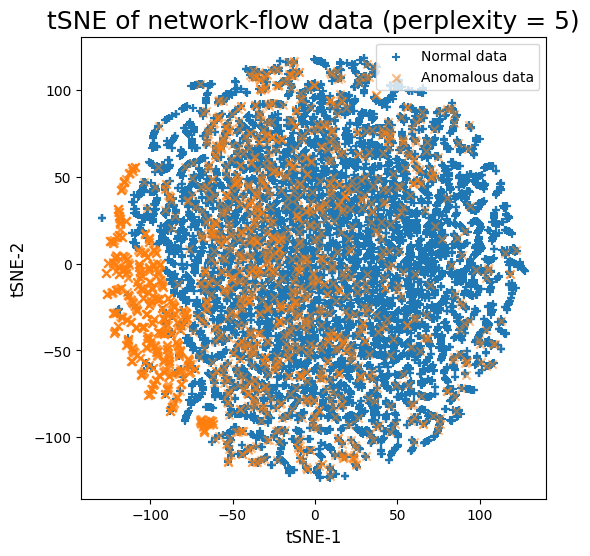

In [6]:
# Plot the result of our TSNE with the label color coded
if True:
    l1, l2 = len(raw_data), len(anomalous_raw)
    fig3 = plt.figure(figsize = (6,6))
    if n_components==3:
        ax1 = fig3.add_subplot(1,1,1, projection='3d')
        ax1.set_zlabel('tSNE-3', fontsize = 12)
        ax1.scatter(tsne_result[:l1, 0], tsne_result[:l1, 1], tsne_result[:l1, 2], np.arange(l1), marker=".").set_label('Normal data')
        ax1.scatter(tsne_result[l1:, 0], tsne_result[l1:, 1], tsne_result[l1:, 2], np.arange(l2), marker="x").set_label('Anomalous data')
    else:
        ax1 = fig3.add_subplot(1,1,1)
        ax1.scatter(tsne_result[:l1,0], tsne_result[:l1,1], marker="+").set_label('Normal data')
        ax1.scatter(tsne_result[l1:,0], tsne_result[l1:,1], marker="x", alpha=0.5).set_label('Anomalous data')
    ax1.set_title(('tSNE of network-flow data (perplexity = ' + str(PERPLEXITY) + ')'), fontsize = 18)
    ax1.set_xlabel('tSNE-1', fontsize = 12)
    ax1.set_ylabel('tSNE-2', fontsize = 12)
    ax1.legend()

    """ # Plot the result of our TSNE with the label color coded
    # A lot of the stuff here is about making the plot look pretty and not TSNE
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': full_label})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0) """

In [17]:
PERPLEXITY = 10
n_components = 2
tsne = TSNE(n_components, perplexity=PERPLEXITY)
tsne_result_raw = tsne.fit_transform(raw_data)
tsne_result_anomalous = tsne.fit_transform(anomalous_raw)

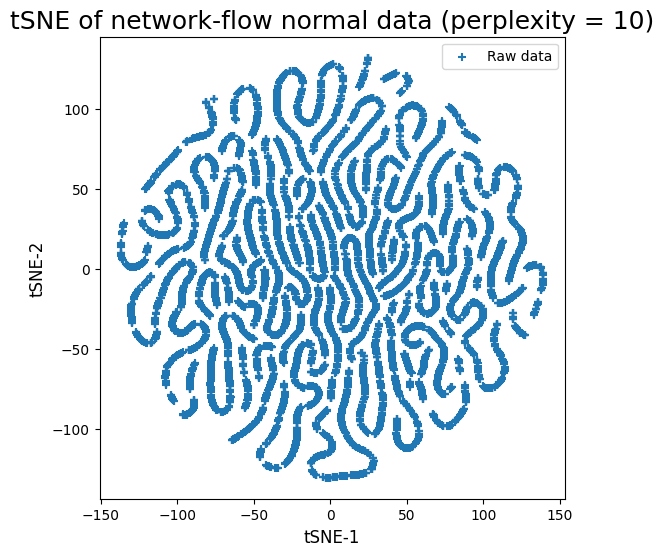

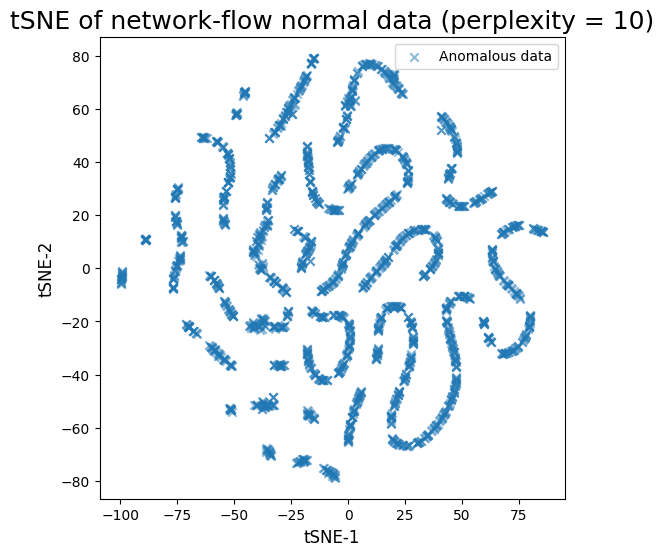

In [18]:
fig1 = plt.figure(figsize = (6,6))
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(tsne_result_raw[:,0], tsne_result_raw[:,1], marker="+").set_label('Raw data')
ax1.set_title(('tSNE of network-flow normal data (perplexity = ' + str(PERPLEXITY) + ')'), fontsize = 18)
ax1.set_xlabel('tSNE-1', fontsize = 12)
ax1.set_ylabel('tSNE-2', fontsize = 12)
ax1.legend()


fig2 = plt.figure(figsize = (6,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.scatter(tsne_result_anomalous[:,0], tsne_result_anomalous[:,1], marker="x", alpha=0.5).set_label('Anomalous data')
ax2.set_title(('tSNE of network-flow normal data (perplexity = ' + str(PERPLEXITY) + ')'), fontsize = 18)
ax2.set_xlabel('tSNE-1', fontsize = 12)
ax2.set_ylabel('tSNE-2', fontsize = 12)
ax2.legend()
